### Imports

In [1]:
import datetime
import pandas as pd
import numpy as np
import sklearn
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import xgboost as xg
import matplotlib.pyplot as plt
import shutil
import requests
import math
import shap

### Load data

In [2]:
data = pd.read_csv('dataset/train.csv')

count = (data['beds'] == 0).sum()
data = data[data['beds'] != 0]
count = (data['beds'] == 0).sum()


msk = np.random.rand(len(data)) <= 0.8

### Process data and train model

In [3]:
data['host_since'] = data['host_since'].fillna('2017-01-22')
data['first_review'] = data['first_review'].fillna('2017-01-22')
data['last_review'] = data['last_review'].fillna('2017-01-22')
data.host_since = pd.to_datetime(data.host_since, format='%Y-%m-%d')
data['host_since_in_years'] = datetime.datetime.now() - data['host_since']
data['host_since_in_years'] = data['host_since_in_years'].apply(lambda x: x.days)
data['host_since_in_years'] = data['host_since_in_years'].apply(lambda x: x/365)
data.host_since_in_years = pd.to_numeric(data.host_since_in_years)
data = data.drop('host_since', axis=1)

# first_review
data.first_review = pd.to_datetime(data.first_review, format='%Y-%m-%d')
data['first_review_in_years'] = datetime.datetime.now() - data['first_review']
data['first_review_in_years'] = data['first_review_in_years'].apply(lambda x: x.days)
data['first_review_in_years'] = data['first_review_in_years'].apply(lambda x: x/365)
data.first_review_in_years = pd.to_numeric(data.first_review_in_years)
data = data.drop('first_review', axis=1)

# last_review
data.last_review = pd.to_datetime(data.last_review, format='%Y-%m-%d')
data['last_review_in_years'] = datetime.datetime.now() - data['last_review']
data['last_review_in_years'] = data['last_review_in_years'].apply(lambda x: x.days)
data['last_review_in_years'] = data['last_review_in_years'].apply(lambda x: x/365)
data.last_review_in_years = pd.to_numeric(data.last_review_in_years)
data = data.drop('last_review', axis=1)

train = data[msk]
test = data[~msk]


binary_variables = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']

categorical_variables = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city',
                         'neighbourhood', 'amenities']

numeric_variables = ['log_price', 'accommodates', 'bathrooms', 'host_response_rate', 'latitude', 'longitude',
                     'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds', 'host_since_in_years', 'first_review_in_years', 'last_review_in_years']  

column_to_drop = ['id', 'name', 'thumbnail_url', 'zipcode', 'description']

columns = {'binary_variables': binary_variables, 'categorical_variables': categorical_variables,
           'numeric_variables': numeric_variables, 'column_to_drop': column_to_drop, 'binned_variables': []}

for column in columns['column_to_drop']:
    train = train.drop(column, axis=1)
    test = test.drop(column, axis=1)

for column in columns['binary_variables']:
    train[column] = train[column].apply(lambda x: True if x == 'TRUE' or x == 't' else False)
    test[column] = test[column].apply(lambda x: True if x == 'TRUE' or x == 't' else False)
    
train['host_response_rate'] = train['host_response_rate'].str.rstrip('%').astype('float') / 100.0
test['host_response_rate'] = test['host_response_rate'].str.rstrip('%').astype('float') / 100.0

for column in columns['numeric_variables']:
    train[column] = train[column].astype(float)
    test[column] = test[column].astype(float)
    
null_columns = []
for column in columns['binary_variables'] + columns['categorical_variables'] + columns['numeric_variables']:
    if train[column].isnull().sum():
        null_columns.append(column)
    if test[column].isnull().sum():
        null_columns.append(column)
        
avg_bath_per_accomm = (train['bathrooms']/train['accommodates']).mean()

train['bathrooms'] = train['bathrooms'].fillna(train['accommodates']*avg_bath_per_accomm)
test['bathrooms'] = test['bathrooms'].fillna(test['accommodates']*avg_bath_per_accomm)
null_columns = list(filter(lambda x : x!='bathrooms', null_columns))


avg_bedrooms_per_accomm = (train['bedrooms']/train['accommodates']).mean()

train['bedrooms'] = train['bedrooms'].fillna(train['accommodates']*avg_bedrooms_per_accomm)
test['bedrooms'] = test['bedrooms'].fillna(test['accommodates']*avg_bedrooms_per_accomm)
null_columns = list(filter(lambda x : x!='bedrooms', null_columns))


avg_beds_per_accomm = (train['beds']/train['accommodates']).mean()

train['beds'] = train['beds'].fillna(train['accommodates']*avg_beds_per_accomm)
test['beds'] = test['beds'].fillna(test['accommodates']*avg_beds_per_accomm)
null_columns = list(filter(lambda x : x!='beds', null_columns))


train_with_most_frequent_values = train.copy()
test_with_most_frequent_values = test.copy()
for column in null_columns:
    val = train_with_most_frequent_values[column].value_counts().index[0]
    train_with_most_frequent_values[column] = train_with_most_frequent_values[column].fillna(val)
    test_with_most_frequent_values[column] = test_with_most_frequent_values[column].fillna(val)

train = train_with_most_frequent_values
test = test_with_most_frequent_values

train = train.reset_index()
test = test.reset_index()

def collect_amenities(data, columns_dict):
    chars_to_remove = '"{}'
    amenities_set = set()
    for line in data['amenities']:
        amenities = line.split(',')
        for obj in amenities:
            for char in chars_to_remove:
                obj = obj.replace(char, "")
            if "translation missing" not in obj and obj != '':
                amenities_set.add(obj)
    for amenity in amenities_set:
        columns_dict['binary_variables'].append(amenity)
    return list(amenities_set)


def create_amenities_array(amenities_list, data):
    amenities_array = []
    for index, row in data.iterrows():
        array = np.zeros(shape=(len(amenities_list)))
        row_amen = data['amenities'][index].split(',')
        for amen in row_amen:
            item = amen.replace('"', '').replace('}', '').replace('{', '')
            if item in amenities_list:
                res = amenities_list.index(item)
                array[res] = 1
        amenities_array.append(array.tolist())

    amenities_df = pd.DataFrame(amenities_array, columns=amenities_list)
    return amenities_df


# converting amenities column to binary columns and updating columns_dict
def create_amenities_cols(data, amenities_set):
    amenities_array = create_amenities_array(amenities_set, data)

    data = data.drop(['amenities'], axis=1)
    data = pd.concat([data, amenities_array], axis=1)

    return data

amenities_list = collect_amenities(train, columns)
train = create_amenities_cols(train, amenities_list)
test = create_amenities_cols(test, amenities_list)
columns['categorical_variables'].remove('amenities')

top_neighbourhoods = train['neighbourhood'].value_counts().head(50).keys()
for index, row in train.iterrows():
    if row['neighbourhood'] not in top_neighbourhoods:
        train.at[index,'neighbourhood'] = 'other'
for index, row in test.iterrows():
    if row['neighbourhood'] not in top_neighbourhoods:
        test.at[index,'neighbourhood'] = 'other'
        
# we leave the target feature as is
oh_train = train['log_price']
oh_test = test['log_price']

# now adding the one hot encoded data
for variable in columns['binned_variables']+columns['categorical_variables']:
    onehot_train_col = pd.get_dummies(train[variable], prefix=variable)
    oh_train = pd.concat([oh_train, onehot_train_col], axis=1)

    onehot_test_col = pd.get_dummies(test[variable], prefix=variable)
    oh_test = pd.concat([oh_test, onehot_test_col], axis=1)
    
for col in columns['binary_variables']:
    train[col] = train[col].replace(True, 1)
    train[col] =train[col].replace(False, 0)
    oh_train = pd.concat([oh_train, train[col]], axis=1)

    test[col] = test[col].replace(True, 1)
    test[col] = test[col].replace(False, 0)
    oh_test = pd.concat([oh_test, test[col]], axis=1)
    
for col in columns['numeric_variables']:
    if col != 'log_price':
        oh_train = pd.concat([oh_train, train[col]], axis=1)

        oh_test = pd.concat([oh_test, test[col]], axis=1)
        
add_to_test = list(set(oh_train.columns) - set(oh_test.columns))
add_to_train = list(set(oh_test.columns) - set(oh_train.columns))
for col in add_to_train:
    oh_train[col] = 0
for col in add_to_test:
    oh_test[col] = 0

oh_test = oh_test[oh_train.columns]

train_y = oh_train['log_price'].values
train_x = oh_train.drop('log_price', axis=1)
test_y = oh_test['log_price'].values
test_x = oh_test.drop('log_price', axis=1)


xgb_r = xg.XGBRegressor()
 

xgb_r.fit(train_x, train_y)
 

prediction_test = xgb_r.predict(test_x)

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.3f}".format(mean_absolute_error(test_y, prediction_test)))
print("Mean Squared Error (Σ(|y-pred|/y)/n):",
      "{:,.3f}".format(mean_squared_error(test_y, prediction_test)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.3f}".
      format(np.sqrt(mean_squared_error(test_y, prediction_test))))
print("r2 score:", "{:,.3f}".format(r2_score(test_y, prediction_test)))

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Mean Absolute Error (Σ|y-pred|/n): 0.274
Mean Squared Error (Σ(|y-pred|/y)/n): 0.142
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0.377
r2 score: 0.716


### Calculate residuals, max over estimated, max under estimated

In [4]:
residuals = test_y - prediction_test
max_over_estimated = abs(min(residuals))
max_under_estimated = max(residuals)
max_over_idx = list(residuals).index(min(residuals))
max_under_idx = list(residuals).index(max(residuals))
print("Max over estimated error (log price):", "{:,.0f}".format(max_over_estimated))
print("Max under estimated error (log price):", "{:,.0f}".format(max_under_estimated))

Max over estimated error (log price): 3
Max under estimated error (log price): 4


<AxesSubplot:>

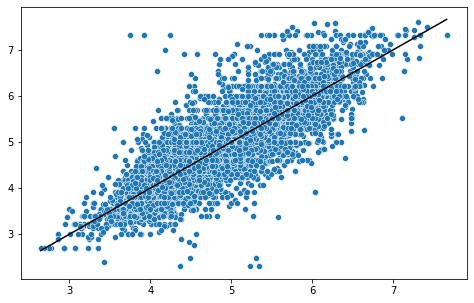

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=prediction_test,y=test_y,ax=ax)
sns.lineplot(x=prediction_test,y=prediction_test,ax=ax,color='black')

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

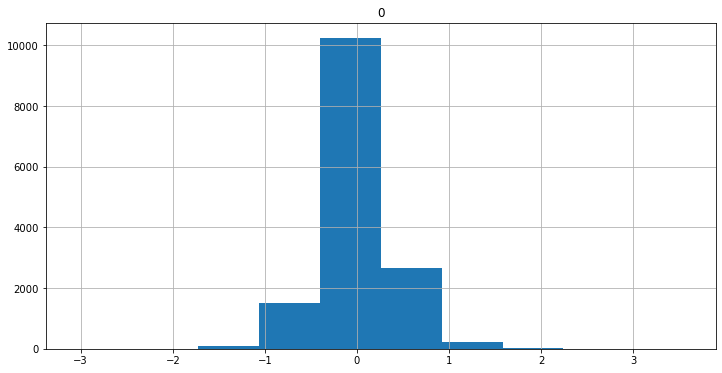

In [6]:
residuals_for_hist = pd.DataFrame(residuals)
residuals_for_hist.hist(figsize=(12,6))

### Calculate relative residuals

In [7]:
rel_res=residuals/test_y
rel_res=abs(rel_res)

In [8]:
len(rel_res[rel_res<0.05])/len(rel_res)

0.554788026547474

In [9]:
len(rel_res[rel_res<0.1])/len(rel_res)

0.8413246647704186

In [10]:
len(rel_res[rel_res>0.2])/len(rel_res)

0.02302587024244887

55% have error less than 5%  
83% of the test data have error less than 10%  
only 2% of the test data have error greater than 20%

####  SHAP analysis of random test examples

Permutation explainer: 501it [00:37,  9.93it/s]                                 


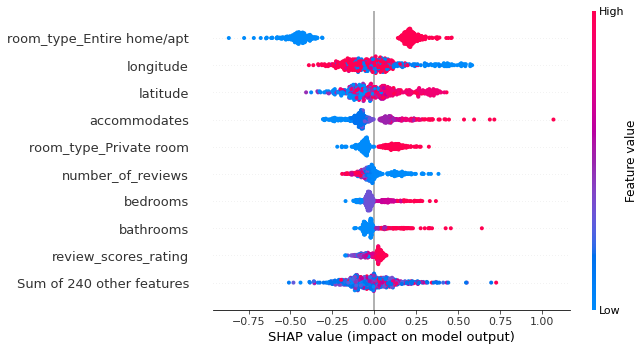

In [11]:
shap_sample = train_x.sample(500)
explainer = shap.Explainer(xgb_r.predict, shap_sample)
shap_values = explainer(shap_sample)
shap.plots.beeswarm(shap_values)

In [12]:
test_shap_values = explainer(test_x)

Permutation explainer: 14767it [19:24, 12.56it/s]                               


In [13]:
# define rel_res again with no abs to get over/under estimates
rel_res=residuals/test_y

In [19]:
rel_res.min()

-1.3228425766113174

In [20]:
rel_res.max()

0.48782627543944374

In [21]:
np.where(rel_res==-1.3228425766113174)

(array([13314]),)

In [24]:
test_y[13314], prediction_test[13314]

(2.302585092994046, 5.3485427)

In [23]:
np.where(rel_res==0.48782627543944374)

(array([13235]),)

In [25]:
test_y[13235], prediction_test[13235]

(7.3132203870903005, 3.7456393)

#### SHAP analysis of single most over estimated example

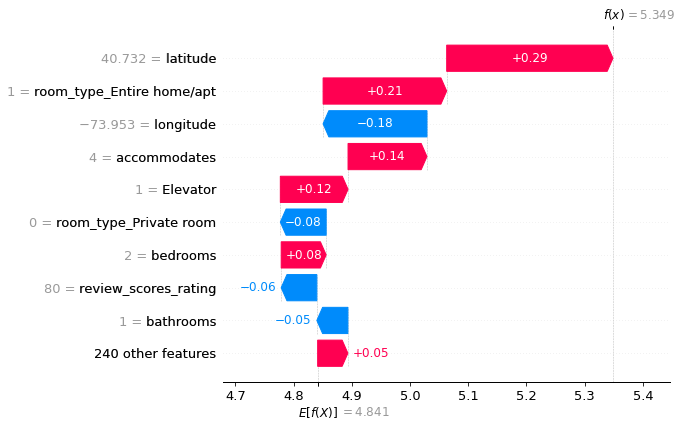

In [27]:
shap.plots.waterfall(test_shap_values[13314])

#### SHAP analysis of single most under estimated example

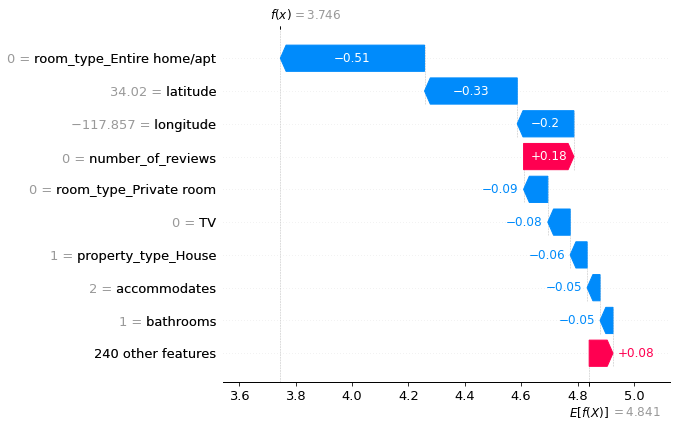

In [28]:
shap.plots.waterfall(test_shap_values[13235])

In [29]:
data['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [30]:
over_estimates = test_x.loc[np.where(rel_res<-0.05)]

#### SHAP analysis of all over estimated examples

Permutation explainer: 3499it [04:43, 11.78it/s]                                


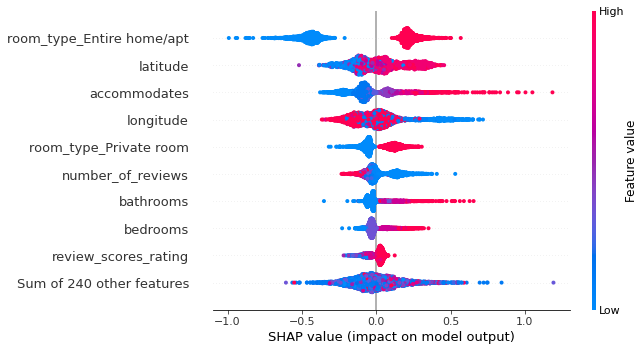

In [31]:
over_estimates_shap_values = explainer(over_estimates)
shap.plots.beeswarm(over_estimates_shap_values)

In [33]:
under_estimates = test_x.loc[np.where(rel_res>0.05)]

#### SHAP analysis of all under estimated examples

Permutation explainer: 3077it [03:53, 12.49it/s]                                


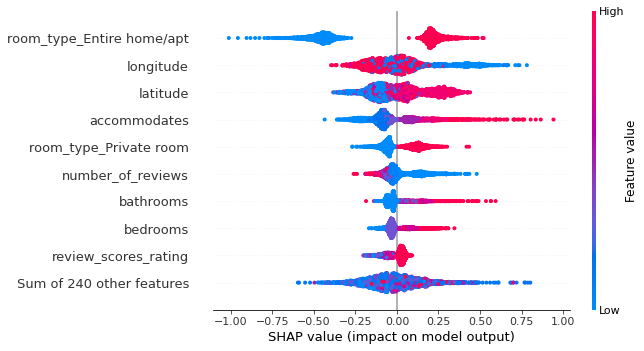

In [34]:
under_estimates_shap_values = explainer(under_estimates)
shap.plots.beeswarm(under_estimates_shap_values)

In [35]:
# apply abs on rel_res to get all good estimates
rel_res=abs(rel_res)
good_estimates = test_x.loc[np.where(rel_res<0.05)]

In [ ]:
good_estimates_shap_values = explainer(good_estimates)
shap.plots.beeswarm(good_estimates_shap_values)

Permutation explainer:  94%|███████████████ | 7706/8192 [10:31<00:31, 15.54it/s]